# Controller Parameter Bounds

The goal of this notebook is to visualize the effect of change in controller params(kp, ki, and alpha) on the system's response to prolonged market deviations(step inputs). This will guide the decisioning on how to bound the controller parameters after ungoverning.

For a review of ki, and alpha parameters and factors when setting the, review this community forum discussion. https://community.reflexer.finance/t/rai-controller-ungovernance/208/7

The lengthy post can also be found as a hackmd doc.
https://hackmd.io/s2uQpHwUS96k3Ox72sybPw

In [113]:
import time
import math
from decimal import Decimal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from sklearn.metrics import mean_squared_error
import scipy.stats as ss


#plt.rcParams['figure.dpi'] = 200 

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,12),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

# Review of RAI redemption price rate calculatiom

$rate(t) = K_p * error(t) + K_i * error\_sum(t)$

where:

$error(t) = target_price(t) - market_price(t)$ 

and $error\_sum$ is the time-decayed sum of previous errors:

$error\_sum(t) = error\_sum(t-1) * {alpha}^{timel\_delta} + (error(t-1) + error(t))/2 * time\_delta$

As the following visualization shows, the error sum(also called error integral), is equal to the time decayed value of the existing error sum plus the new time weighted error.

## Error Sum Calculation Example

![](https://i.imgur.com/CHpFWiQ.png)

___

From the above visualization, you can see that each new error area will be decayed more the older it gets. The new error becomes part of the integral and will thus be decayed each time a new error is added.

For a step input with constant error(constant market deviation), we can create a closed-form solution for the integral after a specific time period using the geometric series.  

Let:

### $error$ be the fixed step error in $USD

### $alpha$ be the chosen value used for integral decay

### $time\_delta$ be the constant time between error updates

Then,  


### $alpha^{time\_delta} = d$ is a constant

and

### $error \cdot time\_delta = c$ is a constant


So the recursive error integral equation becomes.

### $error\_integral(n+1) = error\_integral(n) \cdot d + c \ \ \ \ \ \ \ \ \ (1)$



Equation (1) is the geometric series:
    
### $error\_integral(n) =  c  \sum \limits _{n=0} ^{n-1} d^{i}$


    

We can use the geometric series identity to solve for any $n$




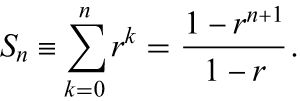

source: https://mathworld.wolfram.com/GeometricSeries.html



### Thus,

### $error\_integral(n) =  c  \sum \limits _{n=0} ^{n-1} d^{i}$

### $error\_integral(n) = c \frac{1 - d^{n}}{1-d}$
### $error\_integral(n) = c \frac{1 - {alpha^{time\_delta}}^{n}}{1-d}$ 

### $error\_integral(n) = c \frac{1 - alpha^{n*time\_delta}}{1-alpha^{time\_delta}}$

### $error\_integral(n) = error \cdot time\_delta \frac{1 - alpha^{n*time\_delta}}{1-alpha^{time\_delta}} \ \ \ \ \ \ \ \ \ (2)$

## Use Equation (2) to find the integral rate after a certain time length of a fixed step(market deviation)

In [2]:
def to_apy(per_sec_rate):
    # Convert per-second rate to annual rate
    return float(((1 + Decimal(per_sec_rate)) ** Decimal(86400*365) - 1) * 100)   

In [88]:

# Equation (2)
def step_integral_rate(error, n_periods, alpha, time_delta, ki):
    # return per-second rate for fixed error after n_periods
    error_sum = Decimal((error * time_delta)) * (1 - Decimal(alpha)**Decimal(n_periods * time_delta))/(1-Decimal(alpha)**Decimal(time_delta))
    
    return float(error_sum) * ki

# total rate: integral rate plus proportional rate
def step_rate(error, n_periods, alpha, time_delta, ki, kp):
    integral_rate = step_integral_rate(error, n_periods, alpha, time_delta, ki)
    p_rate = float(Decimal(error) * Decimal(kp))
    
    return p_rate + integral_rate

In [4]:
r = step_integral_rate(-0.15, 30, 0.999999, 86400, 2.23e-14)
to_apy(r)

-9.68499544456725

## Finding the max error sum and thus max integral rate

We can also use the limit of the geomtric series to find the maxium value the integral sum can attain

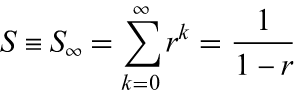

source: https://mathworld.wolfram.com/GeometricSeries.html



The above yields:

# $error\_integral(\infty) = c \sum \limits _{n=0} ^{\infty} d^i$

# $error\_integral(\infty) = c \frac{1}{1-d} = \frac{c}{1-d}$

# $error\_integral(\infty) =  \frac{error \cdot time\_delta}{1-alpha^{time\_delta}} \ \ \ \ \ \ \ \ \ (3)$

In [79]:
# Using Equation 3
def max_integral_rate(error, alpha, time_delta, ki):
    max_error_sum = Decimal(error * time_delta)/ Decimal((1-alpha**time_delta))
    return float(max_error_sum * Decimal(ki))

# total rate: integral rate plus proportional rate
def max_rate(error, alpha, time_delta, ki, kp):
    max_i_rate = max_integral_rate(error, alpha, time_delta, ki)
    p_rate = float(Decimal(error) * Decimal(kp))
    
    return p_rate + max_i_rate

In [6]:
per_sec = max_integral_rate(-0.15, 0.999999, 86400, 2.23e-14)
per_sec

-3.4915829271976615e-09

In [7]:
max_apy = to_apy(per_sec)
max_apy

-10.426490209907925

## Consider some alpha and ki values 

In [8]:
def calc_alpha(n_days):
    # calculate 'n-day' alpha value
    # return alpha st. 95% of the integrals is composed of most recent `n_days` days
    base = Decimal(1 - 0.95)
    
    return float(base**(1/Decimal(86400*n_days)))

In [118]:
#alpha_days = range(0, 390, 30)[1:]
n_days = 50
alpha_days = np.round(np.linspace(30, 720, n_days), 0)
alphas = [calc_alpha(d) for d in alpha_days]
print(alpha_days)

[ 30.  44.  58.  72.  86. 100. 114. 129. 143. 157. 171. 185. 199. 213.
 227. 241. 255. 269. 283. 298. 312. 326. 340. 354. 368. 382. 396. 410.
 424. 438. 452. 467. 481. 495. 509. 523. 537. 551. 565. 579. 593. 607.
 621. 636. 650. 664. 678. 692. 706. 720.]


In [11]:
import numpy as np
n_ki = 50
kis = np.round(np.linspace(1e-14, 8e-14, n_ki), 15)
print(kis)

[1.0e-14 1.1e-14 1.3e-14 1.4e-14 1.6e-14 1.7e-14 1.9e-14 2.0e-14 2.1e-14
 2.3e-14 2.4e-14 2.6e-14 2.7e-14 2.9e-14 3.0e-14 3.1e-14 3.3e-14 3.4e-14
 3.6e-14 3.7e-14 3.9e-14 4.0e-14 4.1e-14 4.3e-14 4.4e-14 4.6e-14 4.7e-14
 4.9e-14 5.0e-14 5.1e-14 5.3e-14 5.4e-14 5.6e-14 5.7e-14 5.9e-14 6.0e-14
 6.1e-14 6.3e-14 6.4e-14 6.6e-14 6.7e-14 6.9e-14 7.0e-14 7.1e-14 7.3e-14
 7.4e-14 7.6e-14 7.7e-14 7.9e-14 8.0e-14]


In [12]:
to_apy(step_integral_rate(-0.15, calc_alpha(120), 86400, 90, 2.23e-14))

-0.0009491061889564688

## Step Integral Rate Heatmap

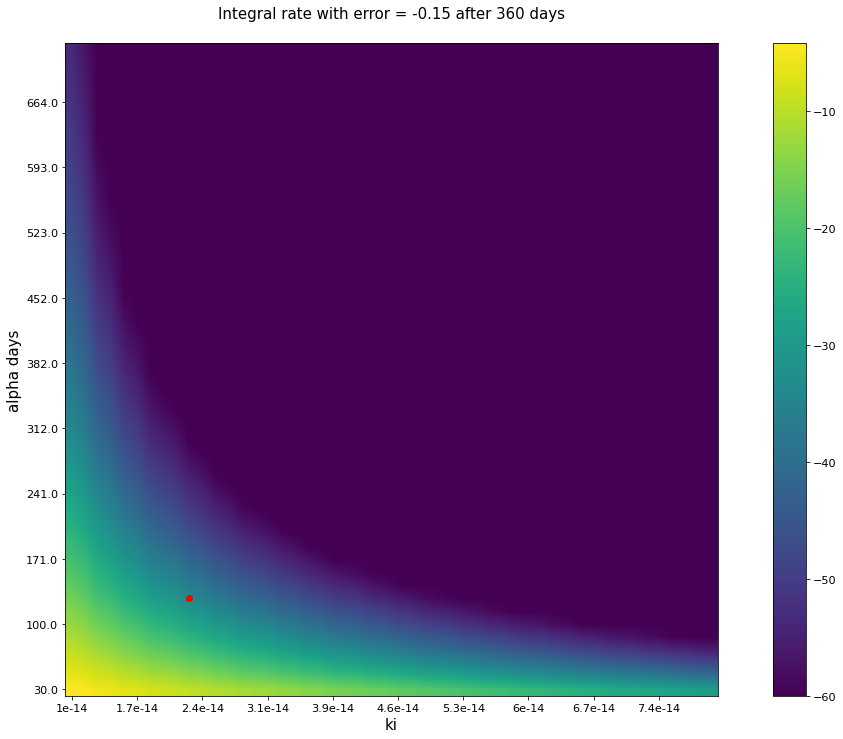

In [117]:
import matplotlib.pyplot as plt
import matplotlib
error = -0.15
time_delta = 86400

step_days = 360
z = np.array([to_apy(step_integral_rate(error, step_days, alpha, time_delta, ki)) for alpha in alphas for ki in kis])
Z = z.reshape(len(alphas), len(kis))

# clip large rates for better viz
Z = np.clip(Z, -60, 0)


fig, ax = plt.subplots(nrows=1, ncols=1)

im = ax.imshow(Z, interpolation='bilinear', origin='lower')

# plot value closest to current Ki, alpha
ax.scatter(np.searchsorted(kis, 2.23e-14), np.searchsorted(alphas, calc_alpha(120)), color='red')

ax.set_xticks(range(0, len(kis), 5))
ax.set_xticklabels(kis[::5])

ax.set_yticks(range(0, len(alpha_days), 5))
ax.set_yticklabels(alpha_days[::5])
ax.set_title(f'Integral rate with error = {error} after {step_days} days')
ax.set_xlabel('ki')
ax.set_ylabel('alpha days')
fig.colorbar(im)
plt.show()

## Step Total Rate Heatmap

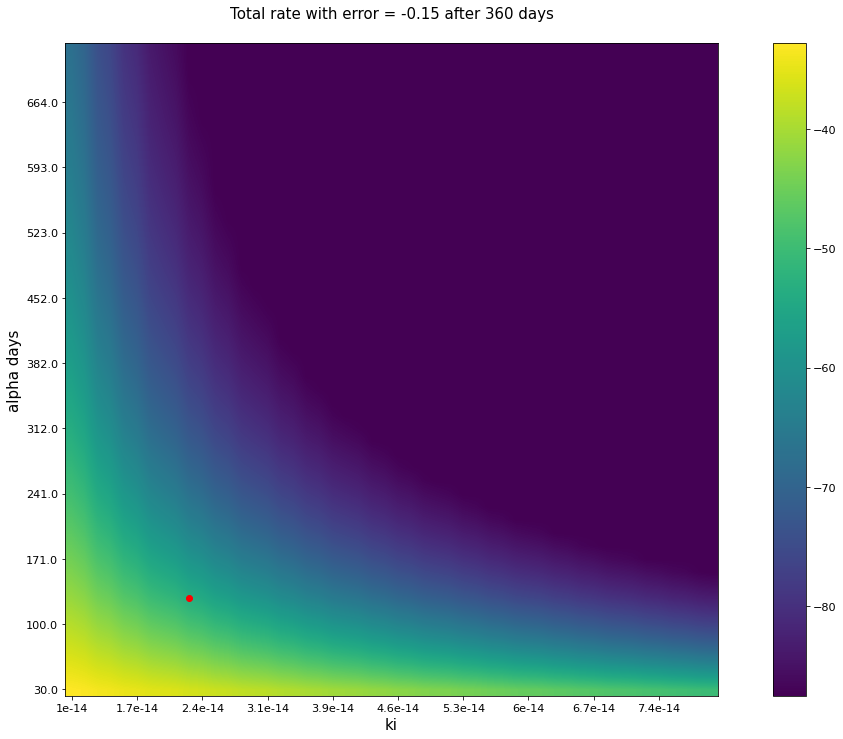

In [111]:
error = -0.15
time_delta = 86400
kp=7.5e-8

#labels = np.array([(alpha, ki) for alpha in alphas for ki in kis])
#labels = labels.reshape(len(kis), len(alphas), 2)
#print(labels)


step_days = 360
z = np.array([to_apy(step_rate(error, step_days, alpha, time_delta, ki, 7.5e-8)) for alpha in alphas for ki in kis])
Z = z.reshape(len(alphas), len(kis))

# clip large rates for better viz
Z = np.clip(Z, -87.5, 0)


fig, ax = plt.subplots(nrows=1, ncols=1)

im = ax.imshow(Z, interpolation='bilinear', origin='lower')
# plot current Ki, alpha
ax.scatter(np.searchsorted(kis, 2.23e-14), np.searchsorted(alphas, calc_alpha(120)), color='red')


ax.set_xticks(range(0, len(kis), 5))
ax.set_xticklabels(kis[::5])

ax.set_yticks(range(0, len(alpha_days), 5))
ax.set_yticklabels(alpha_days[::5])
ax.set_title(f'Total rate with error = {error} after {step_days} days')
ax.set_xlabel('ki')
ax.set_ylabel('alpha days')
fig.colorbar(im)
plt.show()

## Max Integral Rate Heatmap

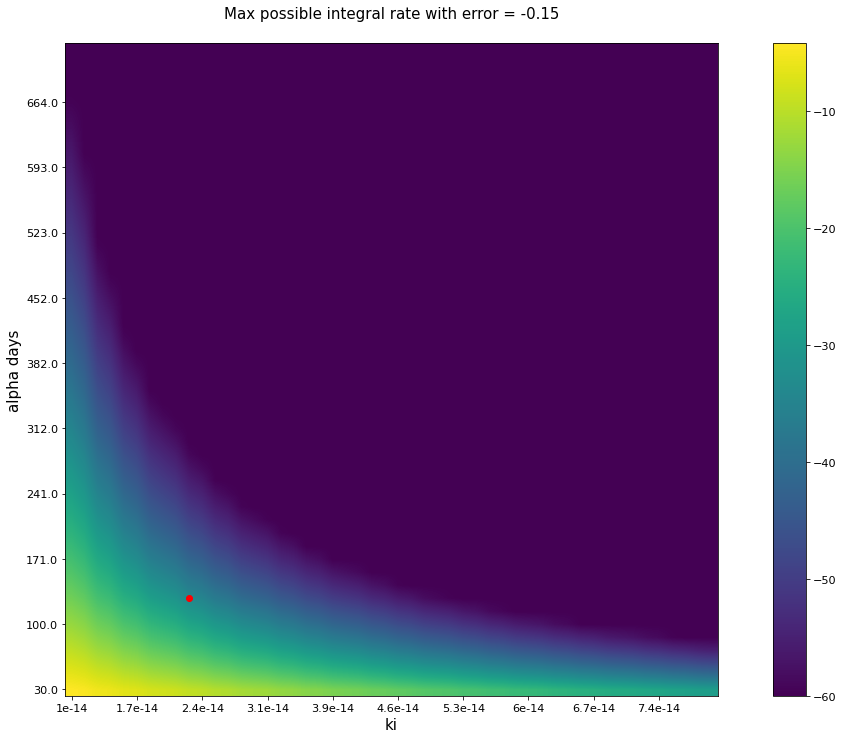

In [108]:

error = -0.15
time_delta = 86400


z = np.array([to_apy(max_integral_rate(error, alpha, time_delta, ki)) for alpha in alphas for ki in kis])
Z = z.reshape(len(alphas), len(kis))

# clip large rates for better viz
Z = np.clip(Z, -60, 0)


fig, ax = plt.subplots(nrows=1, ncols=1)

im = ax.imshow(Z, interpolation='bilinear', origin='lower')

# plot current Ki, alpha
ax.scatter(np.searchsorted(kis, 2.23e-14), np.searchsorted(alphas, calc_alpha(120)), color='red')

#ax.set_xticks(kis)
#ax.set_xticklabels(kis)

ax.set_xticks(range(0, len(kis), 5))
ax.set_xticklabels(kis[::5])

ax.set_yticks(range(0, len(alpha_days), 5))
ax.set_yticklabels(alpha_days[::5])
ax.set_title(f'Max possible integral rate with error = {error}')
ax.set_xlabel('ki')
ax.set_ylabel('alpha days')
fig.colorbar(im)
plt.show()

In [49]:
to_apy(max_integral_rate(0.15, 0.9999999050059570000, 86400, 4.2e-14))

716.6662287026288

In [74]:
to_apy(step_integral_rate(-0.15, 60, 0.9999999050059570000, 86400, 1e-13))

-85.69293684992557

In [102]:
to_apy(max_rate(error=-0.15, alpha=0.9999999050059570000, time_delta=86400, ki=3.5e-14, kp=7.5e-8))

-87.81336555819156

In [107]:
to_apy(step_rate(error=-0.15, n_periods=90, alpha=0.9999999050059570000, time_delta=86400, ki=6.5e-14, kp=7.5e-8))

-87.15416687520931